# Plotting PyPSA results (adapted for the First Run of Bolivia - config.yaml file)

### Adele will check for additional results that can be used


In [3]:
###### algunas cosas cambian si pongo como comentarios en el import de geoviews y hvplot (liberias conflictivas?)

import logging
import os

import pypsa
import yaml
import pandas as pd
import geopandas as gpd
#import geoviews as gv
#import hvplot.pandas 
import numpy as np
import scipy as sp
import networkx as nx

# plotting stuff
import matplotlib.pyplot as plt

plt.style.use("bmh")
import seaborn as sns  ###
import cartopy.crs as ccrs

sns.set(style="darkgrid")

from scipy.sparse import csgraph
from itertools import product

from shapely.geometry import Point, LineString
import shapely, shapely.prepared, shapely.wkt

logger = logging.getLogger(__name__)

pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", 70)

import sys

sys.path.append("../")  # to import helpers
from scripts._helpers import sets_path_to_root

sets_path_to_root("pypsa-earth")

max_node_size = 1.0  # maximum size of a node for plotting purposes [used in plots]

Cant find the repo path.


In [2]:
# utility function for nice plotting


def normalize_node_size(values, max_node_size=max_node_size):
    return values / values.max() * max_node_size

# Load all networks

In [4]:
# add_electricity_network = os.getcwd() + '/networks/elec.nc'
# n_add_el = pypsa.Network(add_electricity_network)

# clustered_network = os.getcwd() + '/networks/elec_s_20.nc'
# n_cluster = pypsa.Network(clustered_network)



#Se carga el documento (o la direccion/path del mismo) a una variable (solved_network)

solved_network = os.getcwd() + "/Users/Lenovo/Desktop/pypsa-earth/results/networks/elec_s_10_ec_lcopt_Co2L-6H.nc"

#Se cargan los resultados de la optimizacion del problema segun las caracteristicas definidas para el modelo en n_solve con la funcion (operador?) Network de pypsa

n_solve = pypsa.Network(solved_network)

INFO:pypsa.io:Imported network elec_s_10_ec_lcopt_Co2L-6H.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


# Solved network

In [6]:
n = n_solve

In [7]:
# ".global_constraints" muestra las restricciones consideradas para el modelo (en el config.yaml solo se tomo en cuenta el limite de emisiones) tonCO2/year

n.global_constraints

,sense,constant,type,investment_period,carrier_attribute,mu
GlobalConstraint,,,,,,
CO2Limit,<=,1.152425e+17,primary_energy,NaN,co2_emissions,0.0


In [8]:
#Calculo del precio promedio de energia promedio en la red (costo total de operacion)= ".objective" /  (sumatoria de las cargas variables en el tiempo)
# EURO/MWh

##### check why the value does not appear


n.objective / n.loads_t.p.sum().sum()

nan

### Spatial temporal resolution

(<matplotlib.collections.PatchCollection at 0x16e79ee7e50>,
 <matplotlib.collections.LineCollection at 0x16e79fa7160>)

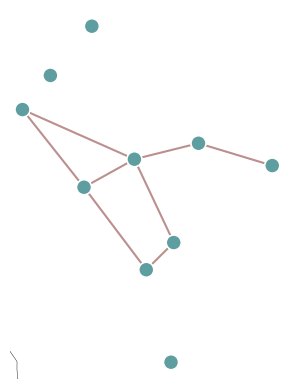

In [9]:
#Resultado grafico de la red electrica ideal (lineas verdes representan expansiones de la red)

#####beacuase all buses are not connected it might be that the problem is not fully solved


n.plot()

In [10]:
#Se muestra el tamaño de la resolucion temporal del modelo - timesteps

len(n.snapshots)

624

### Overview components

In [11]:
#Imprimir la lista de componentes considerados en el dataframe creado

for c in n.iterate_components(list(n.components.keys())[2:]):
    print("Component '{}' has {} entries".format(c.name, len(c.df)))

Component 'Bus' has 30 entries
Component 'Carrier' has 16 entries
Component 'GlobalConstraint' has 1 entries
Component 'Line' has 8 entries
Component 'LineType' has 34 entries
Component 'TransformerType' has 14 entries
Component 'Link' has 40 entries
Component 'Load' has 10 entries
Component 'Generator' has 39 entries
Component 'StorageUnit' has 2 entries
Component 'Store' has 20 entries


### Energy balance

In [12]:
# ".stores_t" hace referencia a la energia que se puede almacenar en un bus (se usa para definir otras tecnologias como storage)
#https://pypsa.readthedocs.io/en/latest/components.html#store

n.stores_t.p.sum()

Series([], dtype: float64)

In [40]:
# se imprimen todos los generadores considerados en el modelo

##### check if loadshedding is being used in the config.yaml file, at the solving section


n.generators

print(type(n.generators))
print(n.generators.columns)
n.generators

<class 'pandas.core.frame.DataFrame'>
Index(['p_nom_max', 'weight', 'p_nom', 'capital_cost', 'efficiency',
       'p_nom_min', 'marginal_cost', 'carrier', 'bus', 'p_nom_extendable',
       'control', 'p_nom_opt', 'sign', 'build_year', 'min_up_time',
       'min_down_time', 'up_time_before', 'down_time_before', 'type',
       'p_min_pu', 'p_max_pu', 'p_set', 'q_set', 'lifetime', 'committable',
       'start_up_cost', 'shut_down_cost', 'ramp_limit_up', 'ramp_limit_down',
       'ramp_limit_start_up', 'ramp_limit_shut_down'],
      dtype='object')


,p_nom_max,weight,p_nom,capital_cost,efficiency,p_nom_min,marginal_cost,carrier,bus,p_nom_extendable,control,p_nom_opt,sign,build_year,min_up_time,min_down_time,up_time_before,down_time_before,type,p_min_pu,p_max_pu,p_set,q_set,lifetime,committable,start_up_cost,shut_down_cost,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down
Generator,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
BO 0 OCGT,inf,0.000000,3.535638e+02,45095.441515,0.41,353.563766,53.534681,OCGT,BO 0,True,Slack,NaN,1.000,0,0,0,1,0,,0.0,1.0,0.0,0.0,inf,False,0.0,0.0,NaN,NaN,1.0,1.0
BO 0 onwind,5.872036e+05,59888.246048,1.218925e+01,96085.888020,1.00,12.189249,0.024966,onwind,BO 0,True,,NaN,1.000,0,0,0,1,0,,0.0,1.0,0.0,0.0,inf,False,0.0,0.0,NaN,NaN,1.0,1.0
BO 0 solar,2.221573e+05,30992.064349,1.126932e+01,35602.071244,1.00,11.269319,0.019491,solar,BO 0,True,,NaN,1.000,0,0,0,1,0,,0.0,1.0,0.0,0.0,inf,False,0.0,0.0,NaN,NaN,1.0,1.0
BO 1 OCGT,inf,0.000000,7.224879e+01,45095.441515,0.41,72.248791,53.534208,OCGT,BO 1,True,,NaN,1.000,0,0,0,1,0,,0.0,1.0,0.0,0.0,inf,False,0.0,0.0,NaN,NaN,1.0,1.0
BO 1 onwind,1.288879e+05,1351.910844,2.186493e-01,96085.888020,1.00,0.218649,0.024894,onwind,BO 1,True,,NaN,1.000,0,0,0,1,0,,0.0,1.0,0.0,0.0,inf,False,0.0,0.0,NaN,NaN,1.0,1.0
BO 1 ror,inf,260.721486,2.607215e+02,299140.224929,0.90,0.000000,0.009357,ror,BO 1,False,,NaN,1.000,0,0,0,1,0,,0.0,1.0,0.0,0.0,inf,False,0.0,0.0,NaN,NaN,1.0,1.0
BO 1 solar,1.612263e+05,30267.135767,1.090383e+01,35602.071244,1.00,10.903831,0.020508,solar,BO 1,True,,NaN,1.000,0,0,0,1,0,,0.0,1.0,0.0,0.0,inf,False,0.0,0.0,NaN,NaN,1.0,1.0
BO 2 OCGT,inf,0.000000,1.078072e+02,45095.441515,0.41,107.807199,53.535201,OCGT,BO 2,True,,NaN,1.000,0,0,0,1,0,,0.0,1.0,0.0,0.0,inf,False,0.0,0.0,NaN,NaN,1.0,1.0
BO 2 oil,inf,0.000000,3.399651e+01,37870.807407,0.35,33.996513,148.866468,oil,BO 2,False,,NaN,1.000,0,0,0,1,0,,0.0,1.0,0.0,0.0,inf,False,0.0,0.0,NaN,NaN,1.0,1.0


In [14]:
#Imprimir solo los generadores de Bolivia

########(check load sheeding to see if load is a problem)

idx = ['BO' in x for x in n.generators.index]
n.generators.loc[idx,:]

,p_nom_max,weight,p_nom,capital_cost,efficiency,p_nom_min,marginal_cost,carrier,bus,p_nom_extendable,control,p_nom_opt,sign,build_year,min_up_time,min_down_time,up_time_before,down_time_before,type,p_min_pu,p_max_pu,p_set,q_set,lifetime,committable,start_up_cost,shut_down_cost,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down
Generator,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
BO 0 OCGT,inf,0.000000,3.535638e+02,45095.441515,0.41,353.563766,53.534681,OCGT,BO 0,True,Slack,NaN,1.000,0,0,0,1,0,,0.0,1.0,0.0,0.0,inf,False,0.0,0.0,NaN,NaN,1.0,1.0
BO 0 onwind,5.872036e+05,59888.246048,1.218925e+01,96085.888020,1.00,12.189249,0.024966,onwind,BO 0,True,,NaN,1.000,0,0,0,1,0,,0.0,1.0,0.0,0.0,inf,False,0.0,0.0,NaN,NaN,1.0,1.0
BO 0 solar,2.221573e+05,30992.064349,1.126932e+01,35602.071244,1.00,11.269319,0.019491,solar,BO 0,True,,NaN,1.000,0,0,0,1,0,,0.0,1.0,0.0,0.0,inf,False,0.0,0.0,NaN,NaN,1.0,1.0
BO 1 OCGT,inf,0.000000,7.224879e+01,45095.441515,0.41,72.248791,53.534208,OCGT,BO 1,True,,NaN,1.000,0,0,0,1,0,,0.0,1.0,0.0,0.0,inf,False,0.0,0.0,NaN,NaN,1.0,1.0
BO 1 onwind,1.288879e+05,1351.910844,2.186493e-01,96085.888020,1.00,0.218649,0.024894,onwind,BO 1,True,,NaN,1.000,0,0,0,1,0,,0.0,1.0,0.0,0.0,inf,False,0.0,0.0,NaN,NaN,1.0,1.0
BO 1 ror,inf,260.721486,2.607215e+02,299140.224929,0.90,0.000000,0.009357,ror,BO 1,False,,NaN,1.000,0,0,0,1,0,,0.0,1.0,0.0,0.0,inf,False,0.0,0.0,NaN,NaN,1.0,1.0
BO 1 solar,1.612263e+05,30267.135767,1.090383e+01,35602.071244,1.00,10.903831,0.020508,solar,BO 1,True,,NaN,1.000,0,0,0,1,0,,0.0,1.0,0.0,0.0,inf,False,0.0,0.0,NaN,NaN,1.0,1.0
BO 2 OCGT,inf,0.000000,1.078072e+02,45095.441515,0.41,107.807199,53.535201,OCGT,BO 2,True,,NaN,1.000,0,0,0,1,0,,0.0,1.0,0.0,0.0,inf,False,0.0,0.0,NaN,NaN,1.0,1.0
BO 2 oil,inf,0.000000,3.399651e+01,37870.807407,0.35,33.996513,148.866468,oil,BO 2,False,,NaN,1.000,0,0,0,1,0,,0.0,1.0,0.0,0.0,inf,False,0.0,0.0,NaN,NaN,1.0,1.0


In [15]:
#Imprimir la suma de potencias nominales (2013) de los generadores de Bolivia

idx = ['BO' in x for x in n.generators.index]
n.generators.loc[idx,:].p_nom.sum()

10000001437.498108

In [16]:
# Difference between total load and generation
# losses = n.stores_t

n.generators_t.p.sum().sum() - n.loads_t.p.sum().sum()  # - substract storage losses


0.0

### Total installed generator capacity

In [18]:
gen_cap = n.generators.groupby(["carrier"]).sum()
gen_cap

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_33568\2958603594.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  gen_cap = n.generators.groupby(["carrier"]).sum()


,p_nom_max,weight,p_nom,capital_cost,efficiency,p_nom_min,marginal_cost,p_nom_extendable,p_nom_opt,sign,build_year,min_up_time,min_down_time,up_time_before,down_time_before,p_min_pu,p_max_pu,p_set,q_set,lifetime,committable,start_up_cost,shut_down_cost,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down
carrier,,,,,,,,,,,,,,,,,,,,,,,,,,,
OCGT,NaN,0.000000,9.143409e+02,270572.649091,2.46,914.340881,321.205995,6,0.0,6.00,0,0,0,6,0,0.0,6.0,0.0,0.0,NaN,0,0.0,0.0,0.0,0.0,6.0,6.0
load,NaN,0.000000,1.000000e+10,0.000000,10.00,0.000000,10.098584,0,0.0,0.01,0,0,0,10,0,0.0,10.0,0.0,0.0,NaN,0,0.0,0.0,0.0,0.0,10.0,10.0
oil,inf,0.000000,3.399651e+01,37870.807407,0.35,33.996513,148.866468,0,0.0,1.00,0,0,0,1,0,0.0,1.0,0.0,0.0,inf,0,0.0,0.0,0.0,0.0,1.0,1.0
onwind,2.376047e+06,124486.370505,2.596471e+01,960858.880200,10.00,25.964709,0.251211,10,0.0,10.00,0,0,0,10,0,0.0,10.0,0.0,0.0,NaN,0,0.0,0.0,0.0,0.0,10.0,10.0
ror,NaN,344.006279,3.440063e+02,598280.449858,1.80,0.000000,0.019715,0,0.0,2.00,0,0,0,2,0,0.0,2.0,0.0,0.0,NaN,0,0.0,0.0,0.0,0.0,2.0,2.0
solar,1.869632e+06,324318.258522,1.191897e+02,356020.712438,10.00,119.189726,0.201915,10,0.0,10.00,0,0,0,10,0,0.0,10.0,0.0,0.0,NaN,0,0.0,0.0,0.0,0.0,10.0,10.0


In [19]:
n.stores_t.p.head()

Store
snapshot
2013-01-01 00:00:00
2013-01-01 06:00:00
2013-01-01 12:00:00
2013-01-01 18:00:00
2013-01-02 00:00:00


<AxesSubplot:xlabel='snapshot'>

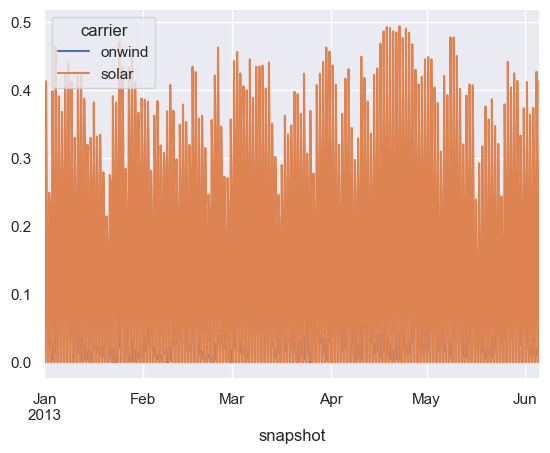

In [20]:
n.generators_t.p_max_pu.groupby(n.generators.carrier, axis=1).mean().plot()

In [21]:
# If 0, all renewable capacity potential is used
n.generators.p_nom_max.sum() - n.generators.p_nom_opt.sum()

inf

In [22]:
n.loads_t.p.sum().sum()

0.0

In [23]:
n.generators_t.p.sum().sum()

0.0

In [24]:
#### pq la multiplicacion?

n.generators.iloc[:, :].groupby(["bus", "carrier"]).p_nom.sum() * 0.0000003

bus   carrier
BO 0  OCGT       1.060691e-04
      load       3.000000e+02
      onwind     3.656775e-06
      solar      3.380796e-06
BO 1  OCGT       2.167464e-05
      load       3.000000e+02
      onwind     6.559479e-08
      ror        7.821645e-05
      solar      3.271149e-06
BO 2  OCGT       3.234216e-05
      load       3.000000e+02
      oil        1.019895e-05
      onwind     1.953577e-06
      solar      1.390673e-05
BO 3  OCGT       4.495021e-05
      load       3.000000e+02
      onwind     0.000000e+00
      ror        2.498544e-05
      solar      9.477031e-07
BO 4  load       3.000000e+02
      onwind     1.681481e-06
      solar      5.814411e-06
BO 5  OCGT       6.538507e-05
      load       3.000000e+02
      onwind     1.198242e-07
      solar      3.911166e-07
BO 6  load       3.000000e+02
      onwind     3.121608e-07
      solar      6.799367e-06
BO 7  load       3.000000e+02
      onwind     0.000000e+00
      solar      1.229392e-07
BO 8  load       3.000000e

AssertionError: Colors not defined for all elements in the second MultiIndex level of bus_sizes, please make sure that all the elements are included in bus_colors or in n.carriers.color

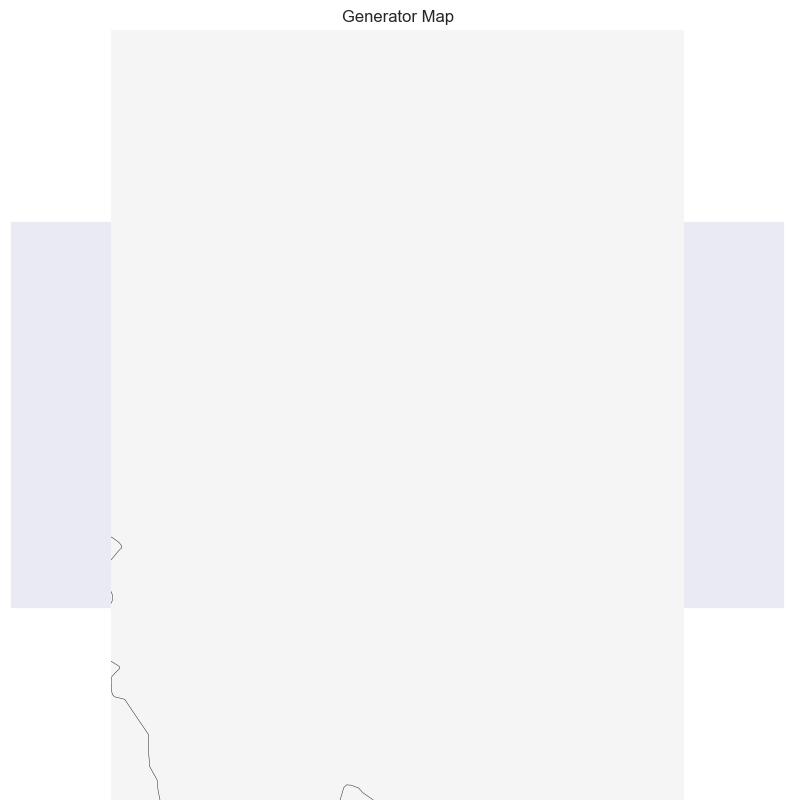

In [25]:
fig, ax = plt.subplots(
    figsize=(10, 10),
    subplot_kw={
        "projection": ccrs.PlateCarree()
    },  # PlateCarree(default), Mercator, Orthographic
)

# loading = (n3.lines_t.p0.abs().mean().sort_index() / (n3.lines.s_nom_opt*n.lines.s_max_pu).sort_index()).fillna(0.)

n.plot(
    margin=0.1,
    ax=None,
    geomap=True,  #'10m' leads to a beautiful high resolution map
    projection=None,
    bus_colors="cadetblue",
    bus_alpha=1,
    bus_sizes=normalize_node_size(
        n.generators.iloc[:, :].groupby(["bus", "carrier"]).p_nom_opt.sum()),
    bus_cmap=None,
    line_colors="rosybrown",
    link_colors="darkseagreen",  # loading
    transformer_colors="orange",
    line_widths=n.lines.s_nom_opt / 3e2,
    link_widths=1.5,
    transformer_widths=1.5,
    line_cmap=None,
    link_cmap=None,  # plt.cm.virdis (colordmap for line loading)
    transformer_cmap=None,
    flow=None,
    branch_components=None,
    layouter=None,
    title="Generator Map",
    boundaries=None,
    geometry=False,
    jitter=None,
    color_geomap=True,
)  # None or True

ax.axis("off");

### Demand

In [26]:
print(type(n.generators.iloc[:, :].groupby(["bus"]).p_nom_opt.sum()))

print(n.generators.iloc[:, :].groupby(["bus"]).p_nom_opt.sum())

<class 'pandas.core.series.Series'>
bus
BO 0    0.0
BO 1    0.0
BO 2    0.0
BO 3    0.0
BO 4    0.0
BO 5    0.0
BO 6    0.0
BO 7    0.0
BO 8    0.0
BO 9    0.0
Name: p_nom_opt, dtype: float64


In [3]:
n.loads_t.p_set.loc["2013-01-01":"2013-06-06","BO 1"].plot()

NameError: name 'n' is not defined

In [30]:
type(n.loads_t.p_set.sum())

pandas.core.series.Series

In [31]:
a = n.loads_t.p_set.sum().rename("load").rename_axis("bus")
a.rename("load", inplace=True)
a.rename_axis("bus", inplace=True)
a

bus
BO 0    165760.688502
BO 1     81159.348527
BO 2    191724.571497
BO 3     66017.013065
BO 4    149443.435993
BO 5     48288.153868
BO 6     73000.693259
BO 7      1794.942286
BO 8     18036.350625
BO 9      7245.822349
Name: load, dtype: float64

In [32]:
n.loads_t.p_set.sum().rename("load").rename_axis("bus")

bus
BO 0    165760.688502
BO 1     81159.348527
BO 2    191724.571497
BO 3     66017.013065
BO 4    149443.435993
BO 5     48288.153868
BO 6     73000.693259
BO 7      1794.942286
BO 8     18036.350625
BO 9      7245.822349
Name: load, dtype: float64

In [33]:
n.generators.iloc[:, :].groupby(["bus"]).p_nom_opt.sum()

###### potencia maxima?
#n.generators.iloc[:, :].groupby(["bus"]).p_max_pu.sum()

bus
BO 0    0.0
BO 1    0.0
BO 2    0.0
BO 3    0.0
BO 4    0.0
BO 5    0.0
BO 6    0.0
BO 7    0.0
BO 8    0.0
BO 9    0.0
Name: p_nom_opt, dtype: float64

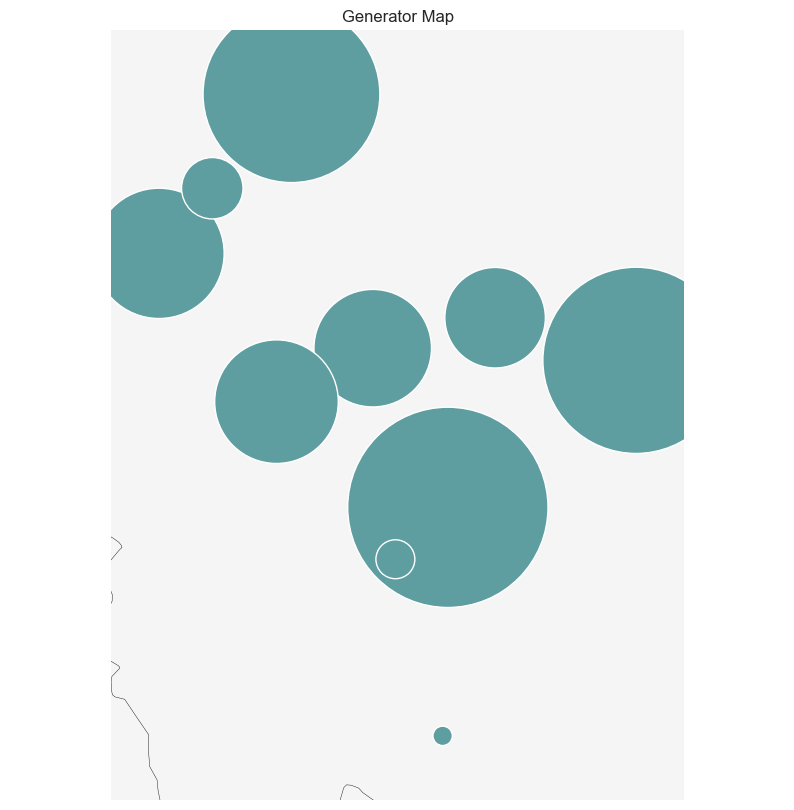

In [34]:
fig, ax = plt.subplots(
    figsize=(10, 10),
    subplot_kw={
        "projection": ccrs.PlateCarree()
    },  # PlateCarree(default), Mercator, Orthographic
)

# loading = (n3.lines_t.p0.abs().mean().sort_index() / (n3.lines.s_nom_opt*n.lines.s_max_pu).sort_index()).fillna(0.)

n.plot(
    margin=0.1,
    ax=None,
    geomap=True,  #'10m' leads to a beautiful high resolution map
    projection=None,
    bus_colors="cadetblue",
    bus_alpha=1,
    bus_sizes=normalize_node_size(
        n.loads_t.p_set.sum().rename("load").rename_axis("bus")
    ),  # n.loads_t.p_set.sum().rename("load").rename_axis("bus")*.0000003,
    bus_cmap=None,
    line_colors="rosybrown",
    link_colors="darkseagreen",  # loading
    transformer_colors="orange",
    line_widths=n.lines.s_nom_opt / 3000000000e2,
    link_widths=1.5,
    transformer_widths=1.5,
    line_cmap=None,
    link_cmap=None,  # plt.cm.virdis (colordmap for line loading)
    transformer_cmap=None,
    flow=None,
    branch_components=None,
    layouter=None,
    title="Generator Map",
    boundaries=None,
    geometry=False,
    jitter=None,
    color_geomap=True,
)  # None or True

ax.axis("off");

In [35]:
# backup
gen_serie = n.generators.iloc[:, :].groupby(["bus", "carrier"]).p_nom_opt.sum()
load_serie = n.loads_t.p_set.sum().rename("load").rename_axis("bus")

load_serie = pd.Series(
    load_serie.values,
    index=pd.MultiIndex.from_tuples([(id, "AC load") for id in load_serie.index]),
)

tot_serie = pd.concat([gen_serie, load_serie])  # .groupby(['bus', 'carrier']).sum()

pd.concat([gen_serie, load_serie])

bus   carrier
BO 0  OCGT            0.000000
      load            0.000000
      onwind          0.000000
      solar           0.000000
BO 1  OCGT            0.000000
      load            0.000000
      onwind          0.000000
      ror             0.000000
      solar           0.000000
BO 2  OCGT            0.000000
      load            0.000000
      oil             0.000000
      onwind          0.000000
      solar           0.000000
BO 3  OCGT            0.000000
      load            0.000000
      onwind          0.000000
      ror             0.000000
      solar           0.000000
BO 4  load            0.000000
      onwind          0.000000
      solar           0.000000
BO 5  OCGT            0.000000
      load            0.000000
      onwind          0.000000
      solar           0.000000
BO 6  load            0.000000
      onwind          0.000000
      solar           0.000000
BO 7  load            0.000000
      onwind          0.000000
      solar           0.0

### Plot of Average Marginal Price

IndexError: index 0 is out of bounds for axis 0 with size 0

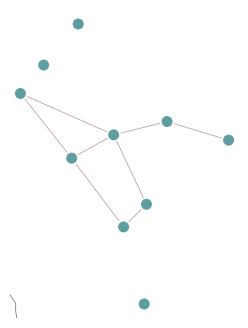

In [36]:
now = n.snapshots[4]  ##one specific time

fig, ax = plt.subplots(1, 1, subplot_kw={"projection": ccrs.PlateCarree()})
fig.set_size_inches(6, 4)

n.plot(ax=ax, line_widths=pd.Series(0.5, n.lines.index))
plt.hexbin(
    n.buses.x,
    n.buses.y,
    gridsize=20,
    # C=n.buses_t.marginal_price.loc[now], #at one time (previous set up by scigrid)
    C=n.buses_t.marginal_price.sum()
    / len(n.snapshots[:]),  # Marginal price averaged over the whole year (My version)
    # - shows in which regions electricity will be cheap and where el. intensive companies should be placed.
    cmap=plt.cm.jet,
)

# for some reason the colorbar only works with graphs plt.plot
# and must be attached plt.colorbar

cb = plt.colorbar()
cb.set_label("Locational Marginal Price (EUR/MWh)")

### Storage

<AxesSubplot:xlabel='snapshot'>

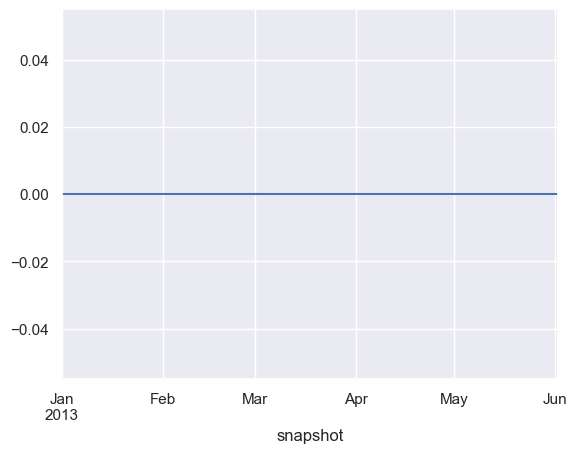

In [37]:
n.stores_t.e.loc["2013-01-01":"2013-06-01"].sum(axis=1).plot()

In [38]:
n.links.iloc[:].groupby(["carrier"]).p_nom_opt.sum()

carrier
H2 electrolysis       0.0
H2 fuel cell          0.0
battery charger       0.0
battery discharger    0.0
Name: p_nom_opt, dtype: float64